In [191]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import graphviz

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [192]:
df = pd.read_csv(r'C:\Users\mattp\Documents\Python\Titanic\train.csv')
df_test = pd.read_csv(r'C:\Users\mattp\Documents\Python\Titanic\test.csv')

To improve our previous model we will try:
 - Removing Sex & Alone as the least useful columns
 - Replacing Embarked & Titles integers with binary values for each location as they look to be important columns
 - Correct Fare per per family member
 - Grid searching for the best model parameters

In [193]:
def consolidate_titles(title,sex):
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'the Countess', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if sex == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

def split_fares(fare):
    if fare < 7.9:
        return 0
    elif fare < 14.5:
        return 1
    elif fare <31.0:
        return 2
    else:
        return 3

def split_fares_per_family(fare):
    if fare < 7.25:
        return 0
    elif fare < 8.3:
        return 1
    elif fare <23.67:
        return 2
    else:
        return 3

def split_ages(age):
    if age < 16:
        return 0
    elif age < 30:
        return 1
    elif age < 45:
        return 2
    elif age < 60:
        return 3
    else:
        return 4

def clean_data(df):
    df.Cabin.fillna(' ', inplace = True)
    df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
    
    # Pull the titles out
    df['Surname'] = df.Name.apply(lambda x: x.split(',')[0])
    df['TempName'] = df.Name.apply(lambda x: (x.split(',')[1]).strip())
    df['Title'] = df.TempName.apply(lambda x: x.split('.')[0])
    df['FirstNames'] = df.TempName.apply(lambda x: (x.split('.')[1]).strip())
    df = df.drop(columns={'Name','TempName'})
    
    df['Title'] = df.apply(lambda x: consolidate_titles(x['Title'],x['Sex']), axis = 1)
    # One Hot Encoded below

    # Check if person is alone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create FarePerFamily and numerically categorize based on .describe()
    df['FarePerFamily'] = df['Fare'] / df['FamilySize']
    
    df['Fare'] = df['Fare'].apply(split_fares)
    df['FarePerFamily'] = df['FarePerFamily'].apply(split_fares_per_family)


    # Remove blanks (S is the most common and take mean age)
    df.Embarked.fillna('S', inplace=True) # One Hot Encoded below
    df.Age.fillna(df.Age.mean(), inplace=True)
    df['Age'] = df['Age'].apply(split_ages)

    # Remap non numerical fields
    df['Sex'] = df['Sex'].map({'male':0,'female':1}).astype(int)
    
    # Too many cabins to have a different variable for each, so just check if passengers have a cabin at all
    df.Cabin.fillna(' ', inplace = True)
    df['CabinTemp'] = df['Cabin'].apply(lambda x: x[0])
    df.CabinTemp.value_counts()
    df['Cabin'] = 0 
    df.loc[df['CabinTemp'] != ' ', 'Cabin'] = 1
    df = df.drop(columns = ['Ticket', 'CabinTemp', 'Surname', 'FirstNames', 'PassengerId','Sex'])
    return df


df = clean_data(df)

In [194]:
to_add_embarked = pd.get_dummies(df.Embarked)
to_add_titles = pd.get_dummies(df.Title)
df = df.join(to_add_embarked)
df = df.join(to_add_titles)
df = df.drop(columns = ['Embarked','Title'])

In [195]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,FamilySize,FarePerFamily,C,Q,S,Master,Miss,Mr,Mrs
0,0,3,1,1,0,0,0,2,0,0,0,1,0,0,1,0
1,1,1,2,1,0,3,1,2,3,1,0,0,0,0,0,1
2,1,3,1,0,0,1,0,1,1,0,0,1,0,1,0,0
3,1,1,2,1,0,3,1,2,3,0,0,1,0,0,0,1
4,0,3,2,0,0,1,0,1,1,0,0,1,0,0,1,0


In [196]:
# Split our dataset and target values
X, y = df.iloc[:,1:],df.iloc[:,0]

# Now we set up our training matrix in a form that can be used by XGBoost
titanic_train_dmatrix = xgb.DMatrix(data=X, label=y)

# Define our paramters to be used in the XGBoost model
params = {'objective':'binary:logistic', 'max_depth':5, 'booster':'gbtree', 'min_child_weight':2, 'eval_metric':'error', \
         'subsample':1}

# Define the splits for our validation
folds = model_selection.KFold(n_splits=3, shuffle=True, random_state=1234)

In [197]:
%%capture
# Define a model to be used. Key points are that we are classifying on a binary decision, are setting a max depth of 5 trees
# and a learning rate of 0.075. As our dataset is on the smaller, we will not be using subsample / colsample_bytree regularization.
model = xgb.XGBClassifier(objective = 'binary:logistic', params = params, n_estimators=50, verbosity = 0, use_label_encoder = False, \
                   early_stopping_rounds = 10, seed = 1234)
model

In [198]:
cv_results = xgb.cv(dtrain=titanic_train_dmatrix, params=params, folds=folds, num_boost_round=100, early_stopping_rounds = 10, \
                   as_pandas=True, seed = 1234)
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.153199,0.001375,0.180696,0.012992
1,0.152638,0.004419,0.177329,0.017675
2,0.150393,0.003459,0.180696,0.007936
3,0.147026,0.004828,0.167228,0.006919


In [199]:
print('The accuracy for our model on is: ', round(1 - cv_results.iloc[-1,2],3)*100,'%',sep = '')

The accuracy for our model on is: 83.3%


In [200]:
params_grid = {
    'colsample_bytree': [0.3, 0.7, 1],
    'min_child_weight': [1, 2, 3, 5],
    'eta': [0.01,0.025,0.05,0.075,0.1,0.2],
    'max_depth': [2,3,4,5,6]
}

In [201]:
%%capture
params = {'objective':'binary:logistic', 'booster':'gbtree', 'eval_metric':'error', 'subsample':1}
# Define a model to be used. Key points are that we are classifying on a binary decision, are setting a max depth of 5 trees
# and a learning rate of 0.075. As our dataset is on the smaller, we will not be using subsample / colsample_bytree regularization.
model = xgb.XGBClassifier(objective = 'binary:logistic', params = params, n_estimators=100, verbosity = 0, use_label_encoder = False, \
                   early_stopping_rounds = 10, seed = 1234)
model

In [202]:
grid_search = GridSearchCV(estimator = model, param_grid = params_grid, scoring = 'error', cv = 3, verbose = 1)

# Fit grid_mse to the data
grid_search.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters found:  {'colsample_bytree': 1, 'eta': 0.05, 'max_depth': 5, 'min_child_weight': 2}


In [203]:
params = {'objective':'binary:logistic', 'booster':'gbtree', 'eval_metric':'error', 'eta':'0.05', 'max_depth':5, 'min_child_weight':2}
model_tuned = xgb.XGBClassifier(objective = 'binary:logistic', params = params, n_estimators=50, verbosity = 0, use_label_encoder = False, \
                   early_stopping_rounds = 10, seed = 1234)
model_tuned

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=10, gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              params={'booster': 'gbtree', 'eta': '0.05',
                      'eval_metric': 'error', 'max_depth': 5,
                      'min_child_weight': 2, 'objective': 'binary:logistic'},
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, seed=1234, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)

In [204]:
cv_results = xgb.cv(dtrain=titanic_train_dmatrix, params=params, folds=folds, num_boost_round=100, early_stopping_rounds = 10, \
                   as_pandas=True, seed = 1234)
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.153199,0.001375,0.180696,0.012992
1,0.153199,0.001375,0.180696,0.012992
2,0.153199,0.001375,0.180696,0.012992
3,0.153199,0.001375,0.180696,0.012992
4,0.153199,0.001375,0.180696,0.012992
5,0.152076,0.002861,0.180696,0.012992
6,0.152076,0.002861,0.180696,0.012992
7,0.152638,0.002100,0.178451,0.014285
8,0.152076,0.002861,0.180696,0.012992
9,0.151515,0.003637,0.178451,0.014285


In [205]:
print('The accuracy for our model on is: ', round(1 - cv_results.iloc[-1,2],3)*100,'%',sep = '')

The accuracy for our model on is: 83.3%


In [206]:
%%capture
# Fit model so we can use the predictors and tree visualisations
model_tuned.fit(X,y)

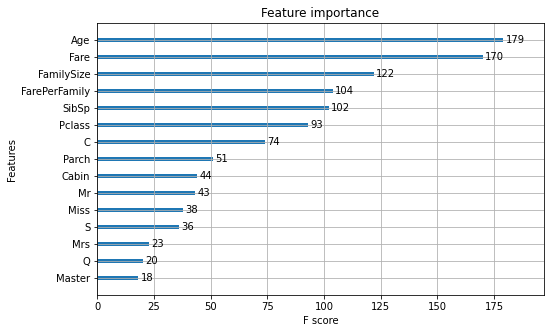

In [207]:
# Plot the most important features through the models we have created.
plt.rcParams['figure.figsize'] = [8,5]
plot_importance(model_tuned, max_num_features = 15)
plt.show()

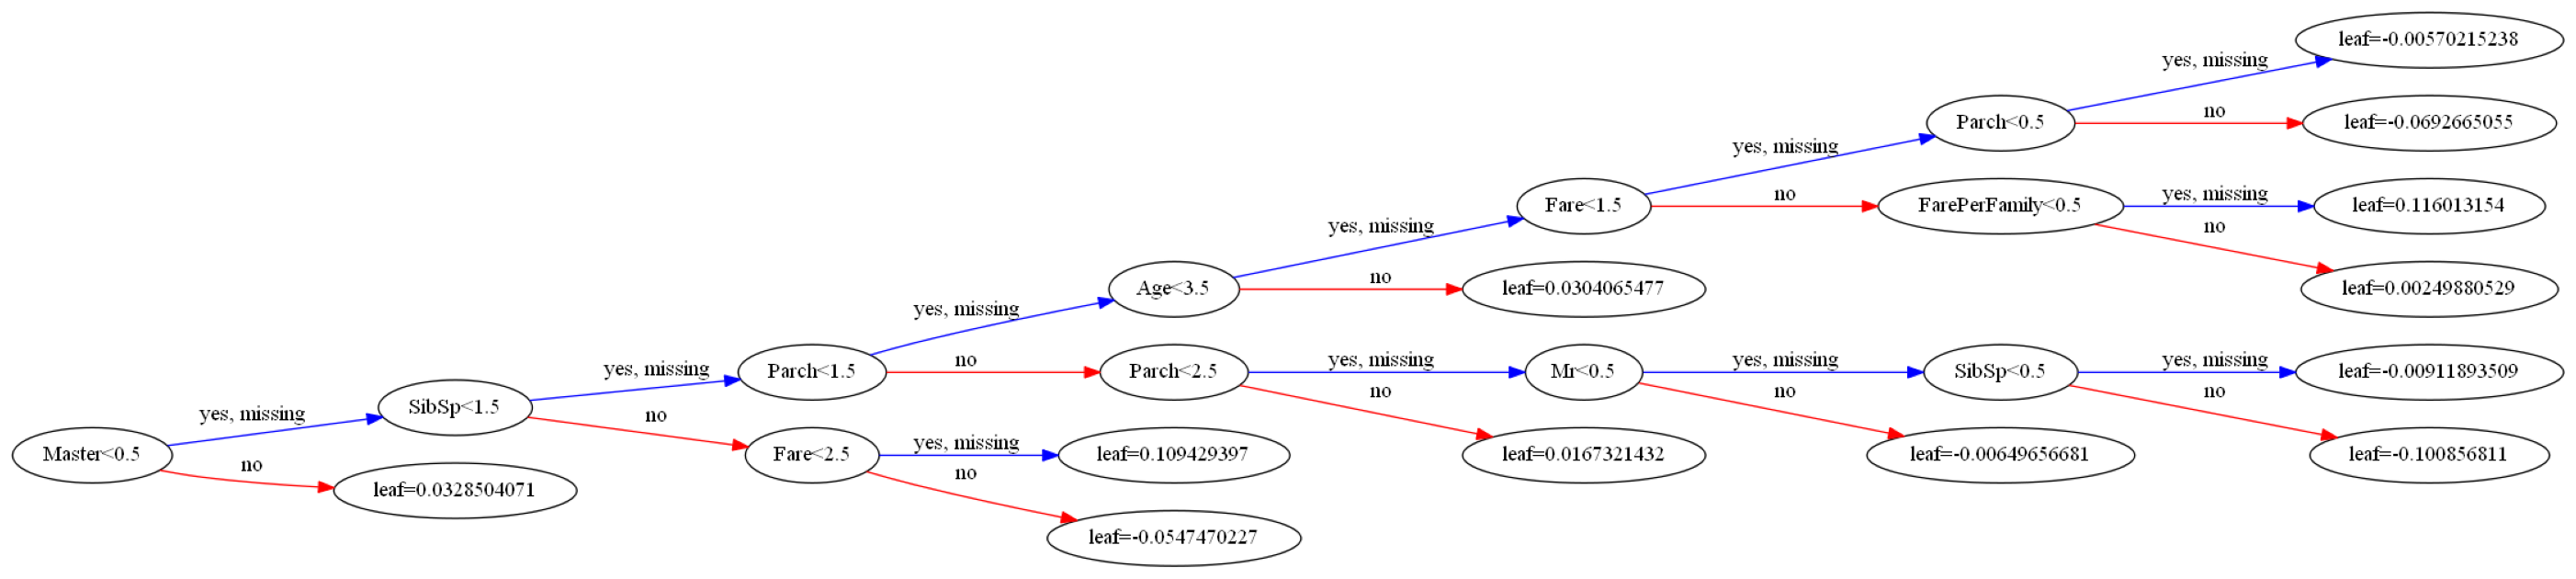

In [209]:
# Plot the final tree produced by the model
xgb.plot_tree(model_tuned,num_trees=cv_results.index.max(), rankdir='LR')
plt.rcParams['figure.figsize'] = [50,25]
plt.show()

In [212]:
df_test_temp = clean_data(df_test)
to_add_embarked = pd.get_dummies(df_test_temp.Embarked)
to_add_titles = pd.get_dummies(df_test_temp.Title)
df_test_temp = df_test_temp.join(to_add_embarked)
df_test_temp = df_test_temp.join(to_add_titles)
df_test_temp = df_test_temp.drop(columns = ['Embarked','Title'])

In [213]:
%%capture
preds = model_tuned.predict(df_test_temp)

In [215]:
df_test['Survived'] = preds
df_preds = df_test.loc[:,['PassengerId','Survived']]
df_preds.to_csv(r'C:\Users\mattp\Documents\Python\Titanic\predictions_improved.csv')